<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

***Some parts of the notebook are almost the exact copy of [ML-MIPT course](https://github.com/girafe-ai/ml-mipt).Special thanks to ML-MIPT team for making them publicly available. [Original notebook](https://github.com/girafe-ai/ml-mipt/blob/master/homeworks_advanced/Lab1_NLP/Lab1_NLP_part_2.ipynb).***

###  Attention

Attention layer can take in the previous hidden state of the decoder $s_{t-1}$, and all of the stacked forward and backward hidden states $H$ from the encoder. The layer will output an attention vector $a_t$, that is the length of the source sentence, each element is between 0 and 1 and the entire vector sums to 1.

Intuitively, this layer takes what we have decoded so far $s_{t-1}$, and all of what we have encoded $H$, to produce a vector $a_t$, that represents which words in the source sentence we should pay the most attention to in order to correctly predict the next word to decode $\hat{y}_{t+1}$. The decoder input word that has been embedded  $y_t$.

You can use any type of the attention scores between previous hidden state of the decoder $s_{t-1}$ and hidden state of the encoder $h \in H$, you prefer. We have met at least three of them:<br><br>

$$\operatorname{score}\left(\boldsymbol{h}, \boldsymbol{s}_{t-1}\right)=\left\{\begin{array}{ll}
\boldsymbol{h}^{\top} \boldsymbol{s}_{t-1} & \text { dot } \\
\boldsymbol{h}^{\top} \boldsymbol{W}_{\boldsymbol{a}} \boldsymbol{s}_{t-1} & \text { general } \\
\boldsymbol{v}_{a}^{\top} \tanh \left(\boldsymbol{W}_{\boldsymbol{a}}\left[\boldsymbol{h} ; \boldsymbol{s}_{t-1}\right]\right) & \text { concat }
\end{array}\right.$$
--------


**_We wil use "concat attention"_**:

First, we calculate the *energy* between the previous decoder hidden state $s_{t-1}$ and the encoder hidden states $H$. As our encoder hidden states $H$ are a sequence of $T$ tensors, and our previous decoder hidden state $s_{t-1}$ is a single tensor, the first thing we do is `repeat` the previous decoder hidden state $T$ times. $\Rightarrow$<br>
We have:<br>
$$H = \bigl[\boldsymbol{h}_{0}, ..., \boldsymbol{h}_{T-1}\bigr] \\ \bigl[\boldsymbol{s}_{t-1}, ..., \boldsymbol{s}_{t-1}\bigr]$$

The encoder hidden dim and the decoder hidden dim should be equal: **dec hid dim = enc hid dim**.<br>
 We then calculate the energy, $E_t$, between them by concatenating them together:<br>

$$\bigl[[\boldsymbol{h}_{0}, \boldsymbol{s}_{t-1}], ..., [\boldsymbol{h}_{T-1}, \boldsymbol{s}_{t-1}]\bigr]$$

And passing them through a linear layer (`attn` = $\boldsymbol{W}_{\boldsymbol{a}}$) and a $\tanh$ activation function:

$$E_t = \tanh(\text{attn}(H, s_{t-1}))$$ 

This can be thought of as calculating how well each encoder hidden state "matches" the previous decoder hidden state.

We currently have a **[enc hid dim, src sent len]** tensor for each example in the batch. We want this to be **[src sent len]** for each example in the batch as the attention should be over the length of the source sentence. This is achieved by multiplying the `energy` by a **[1, enc hid dim]** tensor, $v$.

$$\hat{a}_t = v E_t$$


We can think of this as calculating a weighted sum of the "match" over all `enc_hid_dem` elements for each encoder hidden state, where the weights are learned (as we learn the parameters of $v$).

Finally, we ensure the attention vector fits the constraints of having all elements between 0 and 1 and the vector summing to 1 by passing it through a $\text{softmax}$ layer.

$$a_t = \text{softmax}(\hat{a_t})$$

This gives us the attention over the source sentence!

Graphically, this looks something like below. $z = s_{t-1}$. The green/yellow blocks represent the hidden states from both the forward and backward RNNs, and the attention computation is all done within the pink block.


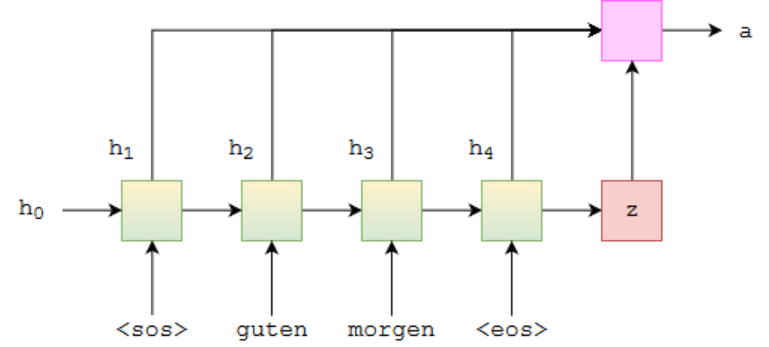

###  Decoder with Attention

To make it really work you should also change the`Decoder` class from the classwork in order to make it to use `Attention`. 
You may just copy-paste `Decoder` class and add several lines of code to it.

The decoder contains the attention layer `attention`, which takes the previous hidden state $s_{t-1}$, all of the encoder hidden states $H$, and returns the attention vector $a_t$.

We then use this attention vector to create a weighted source vector, $w_t$, denoted by `weighted`, which is a weighted sum of the encoder hidden states, $H$, using $a_t$ as the weights.

$$w_t = a_t H$$

The input word that has been embedded $y_t$, the weighted source vector $w_t$, and the previous decoder hidden state $s_{t-1}$, are then all passed into the decoder RNN, with $y_t$ and $w_t$ being concatenated together.

$$s_t = \text{DecoderGRU}([y_t, w_t], s_{t-1})$$

We then pass $y_t$, $w_t$ and $s_t$ through the linear layer, $f$, to make a prediction of the next word in the target sentence, $\hat{y}_{t+1}$. This is done by concatenating them all together.

$$\hat{y}_{t+1} = f(y_t, w_t, s_t)$$

The image below shows decoding the **first** word in an example translation.

The green/yellow blocks show the forward/backward encoder RNNs which output $H$, the red block is $z = s_{t-1} = s_0$ in this moment and $s_0 = h_4$, the blue block shows the decoder RNN which outputs $s_t = s_1$, the purple block shows the linear layer, $f$, which outputs $\hat{y}_{t+1}$ and the orange block shows the calculation of the weighted sum over $H$ by $a_t$ and outputs $w_t$. Not shown is the calculation of $a_t$.

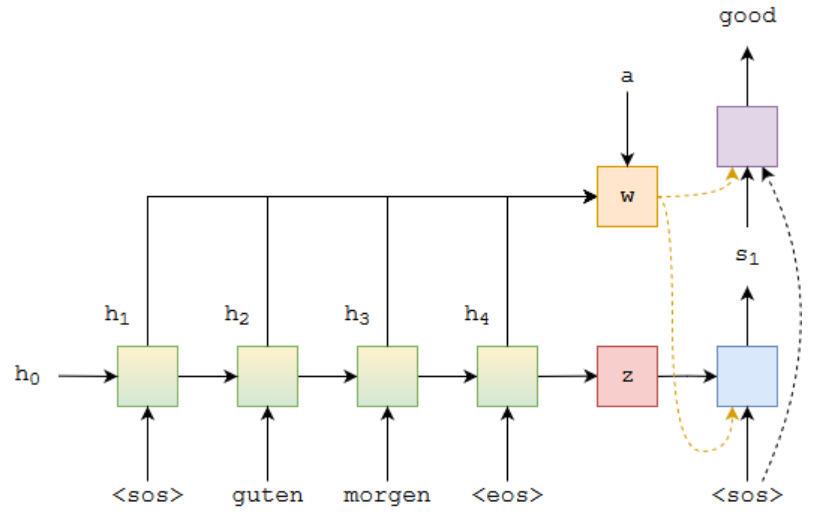

### Teacher forcing

Teacher forcing is a method for quickly and efficiently training recurrent neural network models that use the ground truth from a prior time step as input.

<img src="https://miro.medium.com/max/421/1*U3d8D_GnfW13Y3nDgvwJSw.png">

# Neural Machine Translation

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [ ]:
# ! pip  install subword-nmt
# ! pip install nltk
# ! pip install torchtext
! wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced/homeworks/Lab1_NLP/data.txt

# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

--2020-11-10 00:08:25--  https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced/homeworks/Lab1_NLP/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  21.7MB/s    in 0.6s    

2020-11-10 00:08:26 (21.7 MB/s) - ‘data.txt’ saved [12905334/12905334]



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator, interleave_keys

import random
import math
import time

import pandas as pd

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
# from subword_nmt.learn_bpe import learn_bpe
# from subword_nmt.apply_bpe import BPE


In [ ]:
table = pd.read_csv('data.txt', sep='\t', header=None)

In [ ]:
table = table.drop_duplicates()

## Main part
Here comes the preprocessing. Try to use BPE or more complex preprocessing 


In [ ]:
tokenizer_W = WordPunctTokenizer()

def tokenize_src(x, tokenizer=tokenizer_W):
  return tokenizer.tokenize(x) [::-1]

def tokenize_trg(x, tokenizer=tokenizer_W):
  return tokenizer.tokenize(x)

In [ ]:
SRC = Field(tokenize=tokenize_src,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize_trg,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

In [ ]:
dataset = torchtext.data.TabularDataset(
    path='data.txt', 
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [ ]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [ ]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

And here is example from train dataset:

In [ ]:
print(vars(train_data.examples[9]))

{'trg': ['▁bicycle', '▁rental', '▁is', '▁also', '▁possible', '▁on', '▁site,', '▁all', 'owing', '▁guests', '▁to', '▁explore', '▁the', '▁city', '▁at', '▁their', '▁own', '▁convenience.'], 'src': ['▁в', '▁хостеле', '▁также', '▁можно', '▁взять', '▁напрокат', '▁велосипеды', '▁для', '▁прогулок', '▁по', '▁город', 'у.']}


## Model side


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort=False,
    sort_within_batch=True,
    sort_key=lambda x: interleave_keys(len(x.trg), len(x.src))) 

In [ ]:
def softmax(x, temperature=10): # с tempreture=10, отвечает за гладкость
    # x = [batch_size, src sent len] 
    e_x = torch.exp(x / temperature)
    return e_x / torch.sum(e_x, dim=1).unsqueeze(1) 

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(p=dropout)


    def forward(self, src):
        # src = [sent_len, batch_size]
        embedded = self.dropout(self.embedding(src))
        # embedded = [sent_len, batch_size, emb_dim]

        output, (hidden, cell) = self.rnn(embedded)
        # output = [sent_len, batch_size, 1 * enc_hid_dim]
        # hidden = [n_layers * 1, batch_size, enc_hid_dim]
        
        return output, hidden[-1, :, :].unsqueeze(0), cell 
      

In [ ]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        
        self.attn = nn.Linear(enc_hid_dim + dec_hid_dim, enc_hid_dim)
        self.v = nn.Linear(enc_hid_dim, 1)
        
        
    def forward(self, hidden, encoder_outputs):
        # encoder_outputs = [src sent len, batch size, 1 * enc_hid_dim]
        # hidden = [1, batch size, dec_hid_dim]
        # for the first time hidden is encoders's last hidden 
        # for the next times hidden is decoder's next hidden =>
        # => enc_hid_dim have to be equal to dec_hid_dim
        
        # repeat hidden and concatenate it with encoder_outputs
        # hidden = [1, batch size, dec_hid_dim]
        hidden_r = hidden.repeat(encoder_outputs.size(0), 1, 1)
        # hidden_r = [src sent len, batch size, dec_hid_dim]
        
        hidden_rc = torch.cat((encoder_outputs, hidden_r), dim=2)
        # hidden_rc = [src sent len, batch size, enc_hid_dim + dec_hid_dim]
        
        hidden_rc = hidden_rc.permute(1, 0, 2)
        # hidden_rc = [batch size, src sent len, dec_hid_dim + dec_hid_dim]
        
        # calculate energy
        E = torch.tanh(self.attn(hidden_rc))
        # E = [batch size, src sent len, enc_hid_dim]

        # get attention, use softmax function which is defined, can change temperature
        a = self.v(E) 
        # a = [batch_size, sent_len, 1]

        a = softmax(a)
        # a = [batch_size, src sent len, 1]

        weighted_hidden = a * encoder_outputs.permute(1, 0, 2) 
        # weighted_hidden = [batch, sent_len, enc_hid_dim]

        return torch.sum(weighted_hidden, dim=1) # [batch, enc_hid_dim]

In [ ]:
class DecoderWithAttention(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim + enc_hid_dim, dec_hid_dim, dropout=dropout) # use GRU
        
        self.out = nn.Linear(emb_dim + enc_hid_dim + dec_hid_dim, output_dim)

        self.dropout = nn.Dropout(dropout)


    def forward(self, input, hidden, encoder_outputs):
        
        # input = [batch_size]
        input = input.unsqueeze(0) # because only one word, no words sequence 
        # input = [1, batch_size]
        embedded = self.dropout(self.embedding(input)) 
        # embedded = [1, batch_size, emb_dim]
        
        # get weighted sum of encoder_outputs
        # weighted_enc_hidden = [1, batch_size, enc_hid_dim]
        weighted_enc_hidden = self.attention(hidden, encoder_outputs).unsqueeze(0)

        # concatenate weighted sum and embedded, break through the GRU
        emb_attn_concat = torch.cat((embedded, weighted_enc_hidden), dim=2) 
        # emb_attn_concat = [1, batch_size, enc_hid_dim + emb_dim]

        dec_output, dec_hidden = self.rnn(emb_attn_concat)
        # dec_output = [sent_len = 1, batch_size, 1 * dec_hid_dim] 
        # dec_hidden = [n_layers * n_directions, batch_size, dec_hid_dim] 


        emb_attn_decoutput_concat = torch.cat((emb_attn_concat, dec_output), dim=-1)
        # emb_attn_concat = [1, batch_size, enc_hid_dim + emb_dim]
        # dec_output = [sent_len = 1, batch_size, 1 * dec_hid_dim] 
        # emb_attn_decoutput_concat = [1, batch_size, emb_dim + enc_hid_dim + dec_hid_dim]
        
        predictions = self.out(emb_attn_decoutput_concat)
        # predictions = [1, batch_size, output_dim]

        return predictions.squeeze(0), dec_hidden

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.dec_hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        # src = [src sent len, batch size]
        # trg = [trg sent len, batch size]

        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        # Again, now batch is the first dimension instead of zero
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        enc_states, hidden, cell = self.encoder(src)
        # enc_states = [sent_len, batch_size, enc_hid_dim]
        # hidden = [1, batch_size, enc_hid_dim]

        #first input to the decoder is the <sos> tokens
        input = trg[0,:]


        for t in range(1, max_len):

            output, hidden = self.decoder(input, hidden, enc_states)
            # output = [batch_size, trg_vocab_size] 
            # hidden = [1, batch_size, enc_hidden_dim] 
            # input = [batch_size]
            # hidden of decoder will be encoder's last hidden for the first iteration
            # hidden = [1, batch_size, enc_hidden_dim] 
            # enc_states stands for encoder's hidden dim = [sent_len, batch_size, 1]
            
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]

            # top1 or ground truth
            input = (trg[t] if teacher_force else top1) # trg[t] = [batch_size]
        
        return outputs

In [ ]:
Encoder = Encoder
Attention = Attention
Decoder = DecoderWithAttention
Seq2Seq = Seq2Seq

INPUT_DIM = len(SRC.vocab) 
OUTPUT_DIM = len(TRG.vocab) 
ENC_EMB_DIM = 300 
DEC_EMB_DIM = 300 
HID_DIM = 256 
N_LAYERS = 1 
ENC_DROPOUT = 0.2
DEC_DROPOUT =  0.2

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
attention = Attention(HID_DIM, HID_DIM)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, HID_DIM, DEC_DROPOUT, attention)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9257, 300)
    (rnn): LSTM(300, 256, dropout=0.2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): DecoderWithAttention(
    (attention): Attention(
      (attn): Linear(in_features=512, out_features=256, bias=True)
      (v): Linear(in_features=256, out_features=1, bias=True)
    )
    (embedding): Embedding(6707, 300)
    (rnn): GRU(556, 256, dropout=0.2)
    (out): Linear(in_features=812, out_features=6707, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 11,570,120 trainable parameters


In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters(), lr=1e-3) 
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        output = model(src, trg) # turn off teacher forcing while training
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

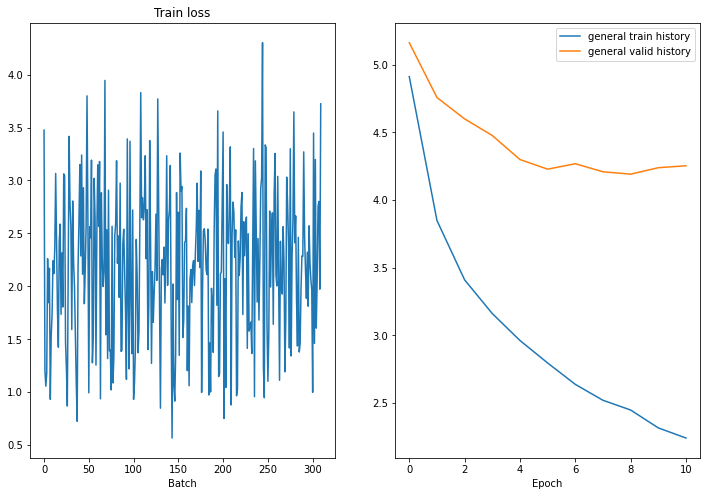

Epoch: 12 | Time: 0m 47s
	Train Loss: 2.187 | Train PPL:   8.908
	 Val. Loss: 4.125 |  Val. PPL:  61.876


In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 12
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [ ]:
def flatten(l):
    return [item for sublist in l for item in sublist]

def remove_tech_tokens(mystr, tokens_to_remove=['<eos>', '<sos>', '<unk>', '<pad>']):
    return [x for x in mystr if x not in tokens_to_remove]


def get_text(x, TRG_vocab):
    # x = [sent]
    text = remove_tech_tokens([TRG_vocab.itos[token] for token in x])
    if len(text) < 1:
        text = []
    return text


def generate_translation(src, trg, model, TRG_vocab):
    model.eval()
    # trg [sent, 1]
    # src [sent, 1]
    # output [sent, batch, trg_vocab_dim]

    output = model(src, trg, 0) #turn off teacher forcing
    output = output[1:, :].argmax(dim=-1).cpu().numpy() 
     
    # trg[:, 0] = [sent] 
    # output[:, 0] = [sent] 

    original = [TRG_vocab.itos[x] for x in list(trg[1:,0].cpu().numpy())]
    generated = [TRG_vocab.itos[x] for x in list(output[:, 0])]
    
    original = remove_tech_tokens(original)
    generated = remove_tech_tokens(generated)
    print('Original: {}'.format(' '.join(original)))
    print('Generated: {}'.format(' '.join(generated)))
    print()


In [ ]:
model.eval()

In [ ]:
batch = next(iter(test_iterator))

for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: all bedrooms have mattresses .
Generated: each room has a - equipped with a

Original: free private parking is provided .
Generated: free private parking is available on site .



### Bleu

[link](https://en.wikipedia.org/wiki/BLEU)

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [ ]:
import tqdm
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output[1:, :].argmax(dim=-1) 
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg[1:, :].cpu().numpy().T]) # trg.T = [batch, sent]
        generated_text.extend([get_text(x, TRG.vocab) for x in output.detach().cpu().numpy().T])


59it [00:03, 18.35it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

23.28270601430586

Baseline solution BLEU score is quite low. 
The checkpoints are:

* __20__ - minimal score to submit
* __25__ - good score to submit